In [1]:
import seaborn as sns
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import os
from PIL import Image
from torchsummary import summary
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/101_ObjectCategories.zip", 'r')
zip_ref.extractall("/content/data_1")
zip_ref.close()

Mounted at /content/drive/


In [3]:
import os
import shutil
import random

dataset_root = '/content/data_1/101_ObjectCategories'
train_root = '/content/datadir/train'
valid_root = '/content/datadir/valid'
test_root = '/content/datadir/test'

os.makedirs(train_root, exist_ok=True)
os.makedirs(valid_root, exist_ok=True)
os.makedirs(test_root, exist_ok=True)

categories = os.listdir(dataset_root)

train_ratio = 0.5
valid_ratio = 0.25
test_ratio = 0.25

for category in categories:
    category_dir = os.path.join(dataset_root, category)
    images = os.listdir(category_dir)

    random.shuffle(images)

    num_images = len(images)
    num_train = int(train_ratio * num_images)
    num_valid = int(valid_ratio * num_images)
    train_images = images[:num_train]
    valid_images = images[num_train:num_train + num_valid]
    test_images = images[num_train + num_valid:]

    train_category_dir = os.path.join(train_root, category)
    valid_category_dir = os.path.join(valid_root, category)
    test_category_dir = os.path.join(test_root, category)

    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(valid_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

    for image in train_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(train_category_dir, image)
        shutil.copy(src, dst)

    for image in valid_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(valid_category_dir, image)
        shutil.copy(src, dst)

    for image in test_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(test_category_dir, image)
        shutil.copy(src, dst)


In [4]:
import torch

datadir = '/content/data_1/101_ObjectCategories'
traindir =  '/content/datadir/train/'
validdir = '/content/datadir/valid/'
testdir = '/content/datadir/test/'

save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []
for d in os.listdir(traindir):
    categories.append(d)

    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df

,category,n_train,n_valid,n_test
54,airplanes,400,200,200
62,Motorbikes,399,199,200
41,BACKGROUND_Google,234,117,117
72,Faces_easy,217,108,110
15,Faces,217,108,110
...,...,...,...,...
59,wild_cat,17,8,9
75,platypus,17,8,9
44,binocular,16,8,9
12,metronome,16,8,8


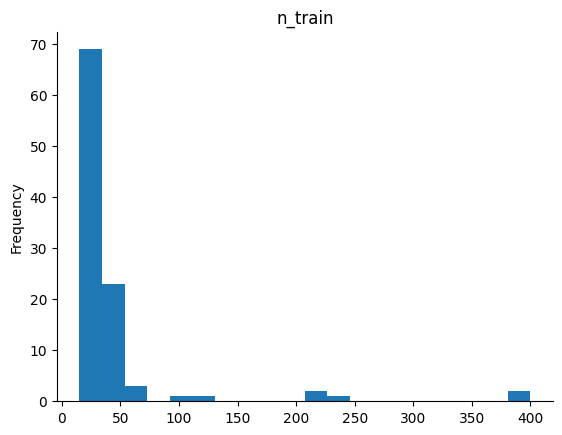

In [6]:
from matplotlib import pyplot as plt
cat_df['n_train'].plot(kind='hist', bins=20, title='n_train')
plt.gca().spines[['top', 'right',]].set_visible(False)

Text(0.5, 1.0, 'Training Images by Category')

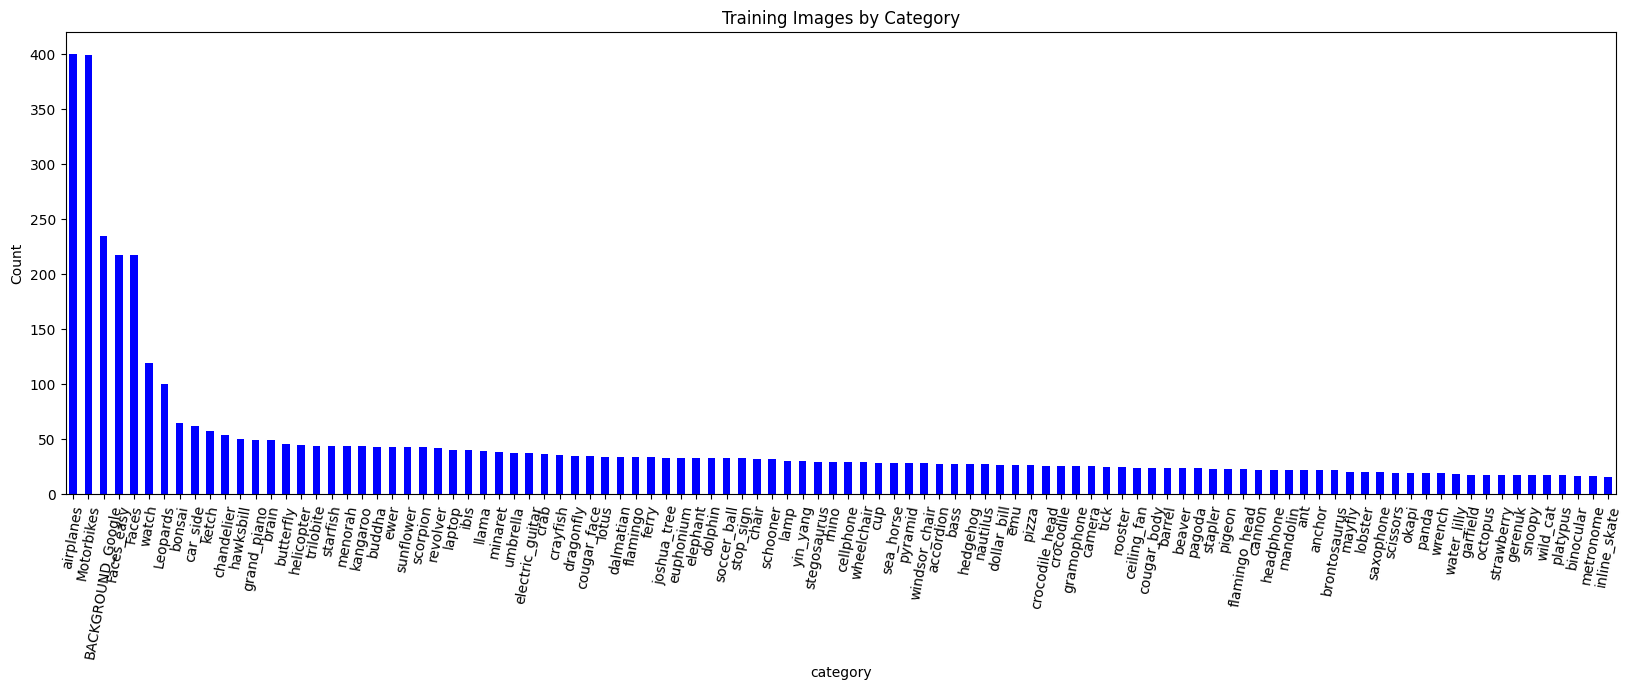

In [7]:
cat_df.set_index('category')['n_train'].plot.bar(
    color='b', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

In [8]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

height                                                       \
                   count        mean         std    min    25%    50%     75%   
category                                                                        
BACKGROUND_Google  234.0  360.914530  367.268763  140.0  188.0  258.5  392.25   
Faces              217.0  331.889401   35.001412  252.0  308.0  325.0  349.00   
Faces_easy         217.0  319.129032   24.258102  259.0  302.0  317.0  333.00   
Leopards           100.0  136.960000   22.319046  128.0  128.0  128.0  128.00   
Motorbikes         399.0  164.265664   18.251856  121.0  151.0  163.0  174.00   

                           width                                               \
                      max  count        mean         std    min    25%    50%   
category                                                                        
BACKGROUND_Google  3999.0  234.0  396.905983  355.263898  140.0  200.0  300.0   
Faces               468.0  217.0  502.617512   52.874995  382.0  466.0  492.0   
Faces_easy          381.0  217.0  275.442396   18.413151  249.0  267.0  273.0   
Leopards            192.0  100.0  183.040000   22.319046  128.0  192.0  192.0   
Motorbikes          226.0  399.0  263.065163    3.742431  249.0  261.0  261.0   

                                  
                     75%     max  
category                          
BACKGROUND_Google  471.0  3481.0  
Faces              528.0   708.0  
Faces_easy         283.0   433.0  
Leopards           192.0   192.0  
Motorbikes         264.0   278.0

In [9]:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:

data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [11]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [12]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 102 different classes.


102

In [13]:
model = models.vgg16(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 153MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
for param in model.parameters():
    param.requires_grad = False

In [15]:
n_inputs = model.classifier[6].in_features

model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=102, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [16]:
model = model.to('cuda')

In [17]:
def get_pretrained_model(model_name):
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)

        for param in model.parameters():
          param.requires_grad = False

        n_inputs = model.classifier[1].in_features
        model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(n_inputs, 256), nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))
    model = model.to('cuda')
    return model

In [31]:
model = get_pretrained_model('mobilenet_v2')
summary(model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 42.8MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 32, 112, 112]             864
       BatchNorm2d-2        [128, 32, 112, 112]              64
             ReLU6-3        [128, 32, 112, 112]               0
            Conv2d-4        [128, 32, 112, 112]             288
       BatchNorm2d-5        [128, 32, 112, 112]              64
             ReLU6-6        [128, 32, 112, 112]               0
            Conv2d-7        [128, 16, 112, 112]             512
       BatchNorm2d-8        [128, 16, 112, 112]              32
  InvertedResidual-9        [128, 16, 112, 112]               0
           Conv2d-10        [128, 96, 112, 112]           1,536
      BatchNorm2d-11        [128, 96, 112, 112]             192
            ReLU6-12        [128, 96, 112, 112]               0
           Conv2d-13          [128, 96, 56, 56]             864
      BatchNorm2d-14          [128, 96,

In [32]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:102]

[(0, 'BACKGROUND_Google'),
 (1, 'Faces'),
 (2, 'Faces_easy'),
 (3, 'Leopards'),
 (4, 'Motorbikes'),
 (5, 'accordion'),
 (6, 'airplanes'),
 (7, 'anchor'),
 (8, 'ant'),
 (9, 'barrel'),
 (10, 'bass'),
 (11, 'beaver'),
 (12, 'binocular'),
 (13, 'bonsai'),
 (14, 'brain'),
 (15, 'brontosaurus'),
 (16, 'buddha'),
 (17, 'butterfly'),
 (18, 'camera'),
 (19, 'cannon'),
 (20, 'car_side'),
 (21, 'ceiling_fan'),
 (22, 'cellphone'),
 (23, 'chair'),
 (24, 'chandelier'),
 (25, 'cougar_body'),
 (26, 'cougar_face'),
 (27, 'crab'),
 (28, 'crayfish'),
 (29, 'crocodile'),
 (30, 'crocodile_head'),
 (31, 'cup'),
 (32, 'dalmatian'),
 (33, 'dollar_bill'),
 (34, 'dolphin'),
 (35, 'dragonfly'),
 (36, 'electric_guitar'),
 (37, 'elephant'),
 (38, 'emu'),
 (39, 'euphonium'),
 (40, 'ewer'),
 (41, 'ferry'),
 (42, 'flamingo'),
 (43, 'flamingo_head'),
 (44, 'garfield'),
 (45, 'gerenuk'),
 (46, 'gramophone'),
 (47, 'grand_piano'),
 (48, 'hawksbill'),
 (49, 'headphone'),
 (50, 'hedgehog'),
 (51, 'helicopter'),
 (52, 'ibi

In [33]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [34]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 1280])
torch.Size([256])
torch.Size([102, 256])
torch.Size([102])


In [35]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):

    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Training Start\n')

    overall_start = timer()

    for epoch in range(n_epochs):

        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        model.train()
        start = timer()

        for ii, (data, target) in enumerate(train_loader):

            data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            loss.backward()

            optimizer.step()

            train_loss += loss.item() * data.size(0)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        else:
            model.epochs += 1

            with torch.no_grad():
                model.eval()

                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()

                    output = model(data)

                    loss = criterion(output, target)

                    valid_loss += loss.item() * data.size(0)
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)


                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])


                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                if valid_loss < valid_loss_min:
                    torch.save(model.state_dict(), save_file_name)
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )


                        model.load_state_dict(torch.load(save_file_name))
                        model.optimizer = optimizer

                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    model.optimizer = optimizer

    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [23]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Training Start


Epoch: 1 	Training Loss: 1.4872 	Validation Loss: 0.9355
		Training Accuracy: 68.22%	 Validation Accuracy: 81.49%

Epoch: 3 	Training Loss: 0.6330 	Validation Loss: 0.5486
		Training Accuracy: 84.40%	 Validation Accuracy: 85.41%

Epoch: 5 	Training Loss: 0.4305 	Validation Loss: 0.4406
		Training Accuracy: 88.86%	 Validation Accuracy: 87.38%

Epoch: 7 	Training Loss: 0.3330 	Validation Loss: 0.4378
		Training Accuracy: 91.46%	 Validation Accuracy: 85.91%

Epoch: 9 	Training Loss: 0.2847 	Validation Loss: 0.3757
		Training Accuracy: 92.12%	 Validation Accuracy: 88.18%

Epoch: 11 	Training Loss: 0.2277 	Validation Loss: 0.3650
		Training Accuracy: 93.93%	 Validation Accuracy: 88.00%

Epoch: 13 	Training Loss: 0.1956 	Validation Loss: 0.3458
		Training Accuracy: 94.70%	 Validation Accuracy: 89.34%

Epoch: 15 	Training Loss: 0.1691 	Validation Loss: 0.3470
		Training Accuracy: 95.42%	 Validation Accuracy: 89.12%

Epoch: 17 	Training Loss: 0.1511 	Validation Loss: 0.3304
		

In [36]:
model_mobilenet, history_mobilenet = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Training Start


Epoch: 1 	Training Loss: 1.7561 	Validation Loss: 1.2424
		Training Accuracy: 60.63%	 Validation Accuracy: 69.36%

Epoch: 3 	Training Loss: 0.7919 	Validation Loss: 0.6983
		Training Accuracy: 80.81%	 Validation Accuracy: 82.34%

Epoch: 5 	Training Loss: 0.5252 	Validation Loss: 0.5348
		Training Accuracy: 86.55%	 Validation Accuracy: 85.01%

Epoch: 7 	Training Loss: 0.4020 	Validation Loss: 0.5157
		Training Accuracy: 89.28%	 Validation Accuracy: 84.70%

Epoch: 9 	Training Loss: 0.3268 	Validation Loss: 0.4465
		Training Accuracy: 91.57%	 Validation Accuracy: 87.42%

Epoch: 11 	Training Loss: 0.2688 	Validation Loss: 0.4302
		Training Accuracy: 92.98%	 Validation Accuracy: 87.02%

Epoch: 13 	Training Loss: 0.2534 	Validation Loss: 0.4455
		Training Accuracy: 92.98%	 Validation Accuracy: 86.13%

Epoch: 15 	Training Loss: 0.2180 	Validation Loss: 0.4495
		Training Accuracy: 93.82%	 Validation Accuracy: 85.99%

Epoch: 17 	Training Loss: 0.1995 	Validation Loss: 0.4543
		

In [30]:
model_vgg16, history_vgg16 = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Training Start


Epoch: 1 	Training Loss: 0.9193 	Validation Loss: 0.6128
		Training Accuracy: 75.77%	 Validation Accuracy: 82.02%

Epoch: 3 	Training Loss: 0.5406 	Validation Loss: 0.5168
		Training Accuracy: 84.62%	 Validation Accuracy: 83.85%

Epoch: 5 	Training Loss: 0.4346 	Validation Loss: 0.4332
		Training Accuracy: 86.84%	 Validation Accuracy: 87.33%

Epoch: 7 	Training Loss: 0.3614 	Validation Loss: 0.4285
		Training Accuracy: 88.78%	 Validation Accuracy: 86.40%

Epoch: 9 	Training Loss: 0.3277 	Validation Loss: 0.4279
		Training Accuracy: 89.77%	 Validation Accuracy: 86.71%

Epoch: 11 	Training Loss: 0.2981 	Validation Loss: 0.4479
		Training Accuracy: 90.76%	 Validation Accuracy: 86.62%

Epoch: 13 	Training Loss: 0.2489 	Validation Loss: 0.4288
		Training Accuracy: 91.99%	 Validation Accuracy: 87.47%

Epoch: 15 	Training Loss: 0.2348 	Validation Loss: 0.4196
		Training Accuracy: 92.45%	 Validation Accuracy: 87.91%

Epoch: 17 	Training Loss: 0.2011 	Validation Loss: 0.4385
		

In [38]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Evaluate the model on the validation set
y_true, y_pred = evaluate_model(model, dataloaders['val'])

# Calculate F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate Precision
precision = precision_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1}")

print(f"Precision: {precision}")

F1 Score: 0.872086209542392
Precision: 0.8875642645900289


In [39]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Evaluate the model on the validation set
y_true, y_pred = evaluate_model(model_vgg16, dataloaders['val'])

# Calculate F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate Precision
precision = precision_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1}")

print(f"Precision: {precision}")

F1 Score: 0.8706929571149873
Precision: 0.8823109851264497


In [40]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Evaluate the model on the validation set
y_true, y_pred = evaluate_model(model_mobilenet, dataloaders['val'])

# Calculate F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate Precision
precision = precision_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1}")

print(f"Precision: {precision}")

F1 Score: 0.872086209542392
Precision: 0.8875642645900289


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=y_true, yticklabels=y_pred)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Text(0.5, 1.0, 'Training and Validation Accuracy for resnet50')

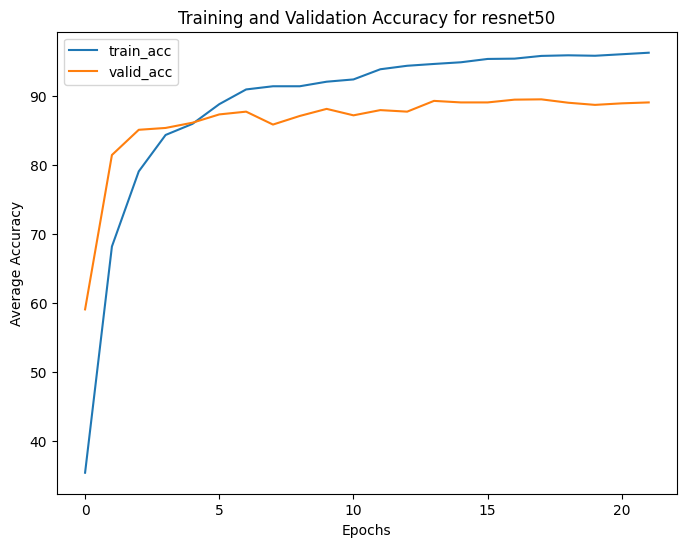

In [42]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy for resnet50')

Text(0.5, 1.0, 'Training and Validation Accuracy for VGG16')

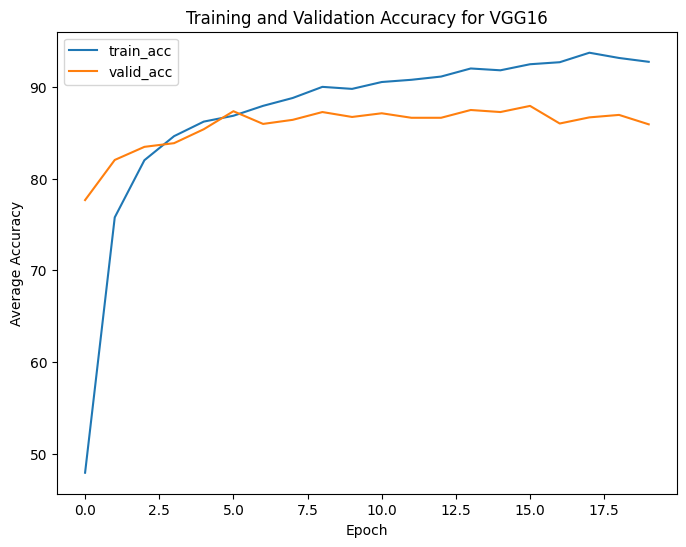

In [44]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history_vgg16[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy for VGG16')

Text(0.5, 1.0, 'Training and Validation Accuracy')

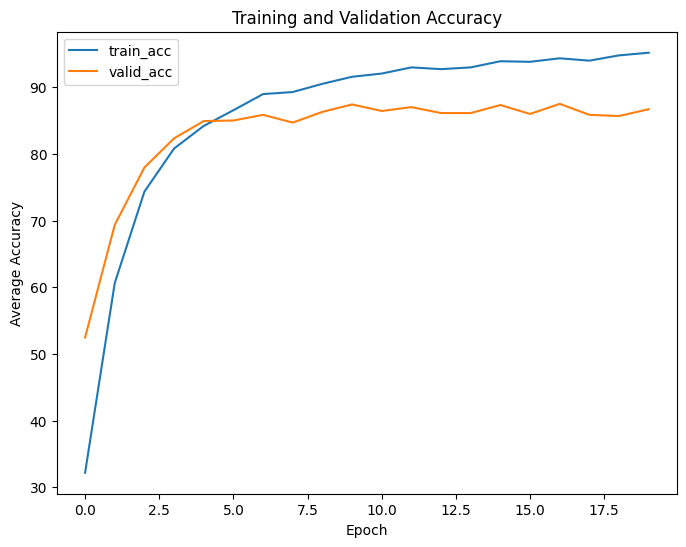

In [45]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history_mobilenet[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')